<a href="https://colab.research.google.com/github/PanoEvJ/Reading-Group-Practical-MLOps/blob/master/GenAI_workshop_img2music_PoC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[phonographioGPT](https://docs.google.com/document/d/1HIWw3V233eM-GXDhOd9F84zs96hiUAM0Sbo_XQmBAxA/edit#)

## Step 0: Requirements

In [ ]:
!pip install spotipy
!pip install transformers
!pip install accelerate

## Step 1: Collect Data (images and MIDI files)

Spotify cover art:
- Install SpotiPY
- Head to https://developer.spotify.com/dashboard/ and log in to Spotify.
   - Select “Create an App”
   - Get your “Client ID” and “Client Secret” from:
     Dashboard > MyApp > Settings > Basic Information
  
     These will be required for accessing the API. Do not share!
- In the cell below, you get authorization. This has worked so far. If something goes wrong try to figure it out [here](https://developer.spotify.com/documentation/web-api/tutorials/code-flow)

In [2]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

client_id = 'YOUR_CLIENT_ID'
client_secret = 'YOUR_CLIENT_SECRET'

client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Search from the album you want using its title name. Retrieve the URL.

In [8]:
album_name = 'Let it bleed'
results = sp.search(q=album_name, type='album')

album_uri = results['albums']['items'][0]['uri']
album = sp.album(album_uri)

image_url = album['images'][0]['url']

'https://i.scdn.co/image/ab67616d0000b2732af30c881bb23cfb82a8cf99'

Display the image using the 'Pillow' library

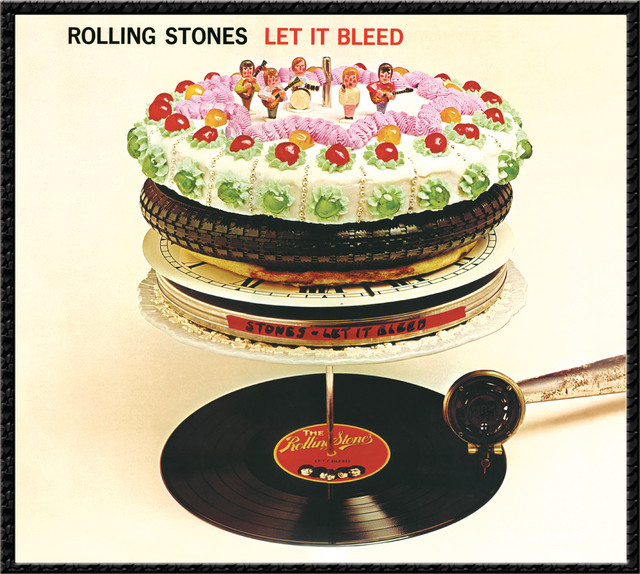

In [12]:
import requests
from PIL import Image

response = requests.get(image_url, stream=True)
image = Image.open(response.raw)

image.show()

## Step 2a: [Image-to-Encodings](https://huggingface.co/docs/transformers/main/en/model_doc/vit#transformers.ViTModel)

    Vision Transformer


In [ ]:
from transformers import AutoImageProcessor, ViTModel
import torch

image_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
model = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")

inputs = image_processor(image, return_tensors="pt")

with torch.no_grad():
    # The outputs are the image encodings
    outputs = model(**inputs)

# last_hidden_states = outputs.last_hidden_state
# list(last_hidden_states.shape)

## Step 2b: [Image-to-Text](https://huggingface.co/nlpconnect/vit-gpt2-image-captioning)

    Vision Transformer + GPT2
      or 
    [BLIP-2](https://huggingface.co/docs/transformers/main/en/model_doc/blip-2#transformers.Blip2QFormerModel) + Prompt (eg "Describe the image")

    Used to generate text from Spotify cover album’s

    Not sure if we keep the encodings from Step_2a or we use text from this step


In [ ]:
from PIL import Image
import requests
from transformers import Blip2Processor, Blip2Model
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")
model = Blip2Model.from_pretrained("Salesforce/blip2-opt-2.7b", torch_dtype=torch.float16)
model.to(device)
# url = "http://images.cocodataset.org/val2017/000000039769.jpg"
# image = Image.open(requests.get(url, stream=True).raw)

prompt = "Question: Describe the image. Answer:"
inputs = processor(images=image, text=prompt, return_tensors="pt").to(device, torch.float16)

outputs = model(**inputs)

For stability purposes, it is recommended to have accelerate installed when using this model in torch.float16, please install it with `pip install accelerate`


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

or use [Vision-CAIR/MiniGPT-4](https://minigpt-4.github.io/)